In [1]:
import math, time, os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms, utils
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("device:", device)

def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(42)


device: cuda


Files already downloaded and verified
x0: torch.Size([128, 3, 32, 32]) y0: [6, 0, 4, 1, 2, 7, 9, 4, 7, 8] ['frog', 'airplane', 'deer', 'automobile', 'bird', 'horse', 'truck', 'deer', 'horse', 'ship']


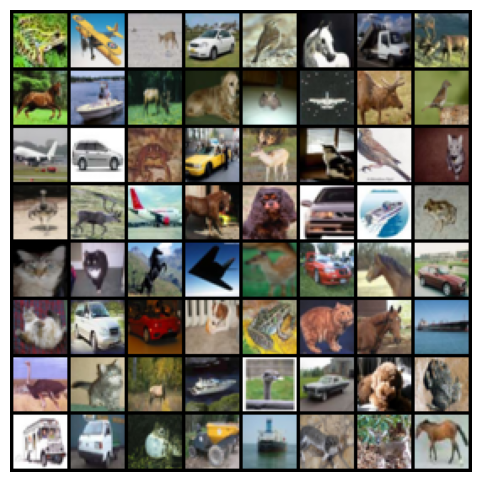

In [2]:
batch_size = 128

class ToMinusOneToOne:
    def __call__(self, x):
        return x * 2 - 1

transform = transforms.Compose([
    transforms.ToTensor(),
    ToMinusOneToOne(),  # [-1, 1]
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0)

cifar10_names = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

x0, y0 = next(iter(train_loader))
print("x0:", x0.shape, "y0:", y0[:10].tolist(), [cifar10_names[i] for i in y0[:10].tolist()])

grid = utils.make_grid((x0[:64] + 1)/2, nrow=8)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0))
plt.axis("off")
plt.show()


In [3]:
T = 1000

def make_beta_schedule(T, beta_start=1e-4, beta_end=2e-2):
    return torch.linspace(beta_start, beta_end, T)

betas = make_beta_schedule(T).to(device)         # (T,)
alphas = 1.0 - betas                             # (T,)
alphas_bar = torch.cumprod(alphas, dim=0)        # (T,)

sqrt_alphas_bar = torch.sqrt(alphas_bar)
sqrt_one_minus_alphas_bar = torch.sqrt(1.0 - alphas_bar)

def extract(a, t, x_shape):
    b = t.size(0)
    return a.gather(0, t).reshape(b, *((1,) * (len(x_shape) - 1)))

def q_sample(x0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x0)
    xt = extract(sqrt_alphas_bar, t, x0.shape) * x0 + extract(sqrt_one_minus_alphas_bar, t, x0.shape) * noise
    return xt, noise


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.012195826..1.0161326].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5286411..1.5102819].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4038241..2.335457].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.4651057..2.6541345].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.545088..2.579825].


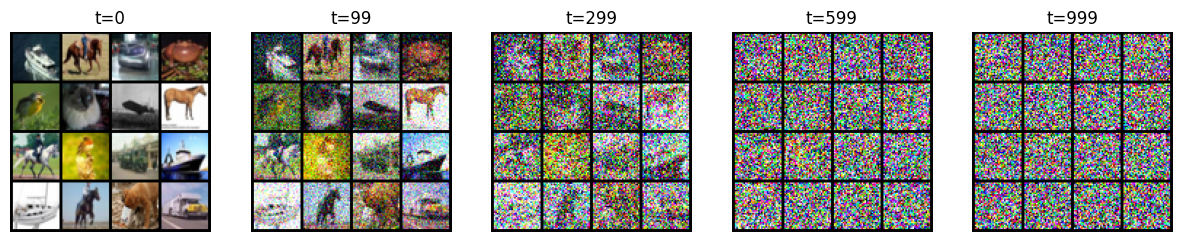

In [4]:
@torch.no_grad()
def show_noising_steps(x0, ratios=(0.0, 0.1, 0.3, 0.6, 1.0), n=16):
    x0 = x0[:n].to(device)
    fig, axes = plt.subplots(1, len(ratios), figsize=(3*len(ratios), 3))
    for i, r in enumerate(ratios):
        t_val = int(r * (T - 1))
        t = torch.full((x0.size(0),), t_val, device=device, dtype=torch.long)
        xt, _ = q_sample(x0, t)
        grid = utils.make_grid((xt + 1)/2, nrow=int(math.sqrt(n)))
        axes[i].imshow(grid.permute(1,2,0).cpu())
        axes[i].set_title(f"t={t_val}")
        axes[i].axis("off")
    plt.show()

x0, _ = next(iter(train_loader))
show_noising_steps(x0)


In [5]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, t):
        device = t.device
        half = self.dim // 2
        emb = math.log(10000) / (half - 1)
        emb = torch.exp(torch.arange(half, device=device) * -emb)
        emb = t.float().unsqueeze(1) * emb.unsqueeze(0)
        return torch.cat([emb.sin(), emb.cos()], dim=1)

class TimeMLP(nn.Module):
    def __init__(self, tdim):
        super().__init__()
        self.net = nn.Sequential(
            SinusoidalPosEmb(tdim),
            nn.Linear(tdim, tdim * 4),
            nn.SiLU(),
            nn.Linear(tdim * 4, tdim),
        )

    def forward(self, t):
        return self.net(t)


In [6]:
class ResBlock(nn.Module):
    def __init__(self, ch, tdim, dropout=0.1):
        super().__init__()
        self.norm1 = nn.GroupNorm(8, ch)
        self.conv1 = nn.Conv2d(ch, ch, 3, padding=1)

        self.norm2 = nn.GroupNorm(8, ch)
        self.conv2 = nn.Conv2d(ch, ch, 3, padding=1)
        self.dropout = nn.Dropout(dropout)

        self.time_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(tdim, ch)
        )

    def forward(self, x, t_emb):
        h = self.conv1(F.silu(self.norm1(x)))
        h = h + self.time_proj(t_emb).unsqueeze(-1).unsqueeze(-1)
        h = self.conv2(self.dropout(F.silu(self.norm2(h))))
        return x + h

class Downsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 3, stride=2, padding=1)

    def forward(self, x):
        return self.conv(x)

class Upsample(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.conv = nn.Conv2d(ch, ch, 3, padding=1)

    def forward(self, x):
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        return self.conv(x)

class AttnBlock(nn.Module):
    def __init__(self, ch):
        super().__init__()
        self.norm = nn.GroupNorm(8, ch)
        self.q = nn.Conv2d(ch, ch, 1)
        self.k = nn.Conv2d(ch, ch, 1)
        self.v = nn.Conv2d(ch, ch, 1)
        self.proj = nn.Conv2d(ch, ch, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        n = h * w

        h_ = self.norm(x)
        q = self.q(h_).reshape(b, c, n).permute(0, 2, 1)  # (B, N, C)
        k = self.k(h_).reshape(b, c, n)                   # (B, C, N)
        v = self.v(h_).reshape(b, c, n).permute(0, 2, 1)  # (B, N, C)

        attn = torch.bmm(q, k) * (c ** -0.5)              # (B, N, N)
        attn = torch.softmax(attn, dim=-1)

        out = torch.bmm(attn, v).permute(0, 2, 1).reshape(b, c, h, w)
        return x + self.proj(out)


In [7]:
class ConditionalUNetCIFAR(nn.Module):
    def __init__(self, num_classes=10, base_ch=128, tdim=256, dropout=0.1):
        super().__init__()
        self.time_mlp = TimeMLP(tdim)
        self.label_emb = nn.Embedding(num_classes, tdim)

        self.in_conv = nn.Conv2d(3, base_ch, 3, padding=1)

        # 32x32
        self.res1a = ResBlock(base_ch, tdim, dropout)
        self.res1b = ResBlock(base_ch, tdim, dropout)
        self.down1 = Downsample(base_ch)   # 32->16

        # 16x16
        self.res2a = ResBlock(base_ch, tdim, dropout)
        self.res2b = ResBlock(base_ch, tdim, dropout)
        self.attn16 = AttnBlock(base_ch)
        self.down2 = Downsample(base_ch)   # 16->8

        # 8x8
        self.res3a = ResBlock(base_ch, tdim, dropout)
        self.res3b = ResBlock(base_ch, tdim, dropout)
        self.attn8 = AttnBlock(base_ch)

        # bottleneck
        self.mid1 = ResBlock(base_ch, tdim, dropout)
        self.mid_attn = AttnBlock(base_ch)
        self.mid2 = ResBlock(base_ch, tdim, dropout)

        # up 8->16
        self.up2 = Upsample(base_ch)
        self.up2_conv = nn.Conv2d(base_ch, base_ch, 3, padding=1)
        self.ures2a = ResBlock(base_ch, tdim, dropout)
        self.ures2b = ResBlock(base_ch, tdim, dropout)
        self.uattn16 = AttnBlock(base_ch)

        # up 16->32
        self.up1 = Upsample(base_ch)
        self.up1_conv = nn.Conv2d(base_ch, base_ch, 3, padding=1)
        self.ures1a = ResBlock(base_ch, tdim, dropout)
        self.ures1b = ResBlock(base_ch, tdim, dropout)

        self.out = nn.Conv2d(base_ch, 3, 1)

    def forward(self, x, t, y):
        cond = self.time_mlp(t) + self.label_emb(y)  # (B, tdim)

        x = self.in_conv(x)

        # 32
        x1 = self.res1b(self.res1a(x, cond), cond)
        x = self.down1(x1)

        # 16
        x2 = self.res2b(self.res2a(x, cond), cond)
        x2 = self.attn16(x2)
        x = self.down2(x2)

        # 8
        x3 = self.res3b(self.res3a(x, cond), cond)
        x3 = self.attn8(x3)

        # mid
        x = self.mid2(self.mid_attn(self.mid1(x3, cond)), cond)

        # up 8->16 (skip x2)
        x = self.up2(x)
        x = self.up2_conv(x + x2)
        x = self.ures2b(self.ures2a(x, cond), cond)
        x = self.uattn16(x)

        # up 16->32 (skip x1)
        x = self.up1(x)
        x = self.up1_conv(x + x1)
        x = self.ures1b(self.ures1a(x, cond), cond)

        return self.out(x)

model = ConditionalUNetCIFAR(num_classes=10, base_ch=128, tdim=256, dropout=0.1).to(device)
print("params:", f"{sum(p.numel() for p in model.parameters()):,}")


params: 5,625,731


In [8]:
alphas_bar_prev = torch.cat([torch.tensor([1.0], device=device), alphas_bar[:-1]], dim=0)
posterior_var = betas * (1.0 - alphas_bar_prev) / (1.0 - alphas_bar)  # (T,)

In [9]:
lr = 1e-4
epochs = 30
log_every = 100

opt = torch.optim.AdamW(model.parameters(), lr=lr)

def train_one_epoch(epoch):
    model.train()
    total_loss, n = 0.0, 0

    epoch_start = time.time()
    last_log = time.time()

    for step, (x0, y) in enumerate(train_loader, start=1):
        step_start = time.time()

        x0 = x0.to(device)
        y = y.to(device)

        t = torch.randint(0, T, (x0.size(0),), device=device, dtype=torch.long)
        xt, noise = q_sample(x0, t)

        pred = model(xt, t, y)
        loss = F.mse_loss(pred, noise)

        opt.zero_grad(set_to_none=True)
        loss.backward()
        opt.step()

        total_loss += loss.item() * x0.size(0)
        n += x0.size(0)

        if step % log_every == 0:
            now = time.time()
            avg_step_ms = (now - last_log) / log_every * 1000
            last_log = now
            step_ms = (time.time() - step_start) * 1000
            print(f"[ep {epoch:02d} | step {step:05d}] loss={loss.item():.4f} | step={step_ms:.1f}ms | avg={avg_step_ms:.1f}ms")

    avg_loss = total_loss / n
    print(f"[ep {epoch:02d} DONE] avg_loss={avg_loss:.4f} | epoch_time={time.time()-epoch_start:.1f}s")
    return avg_loss

for ep in range(1, epochs + 1):
    train_one_epoch(ep)

os.makedirs("./ckpt", exist_ok=True)
torch.save(model.state_dict(), "./ckpt/ddpm_cifar10_conditional.pt")
print("saved: ./ckpt/ddpm_cifar10_conditional.pt")


[ep 01 | step 00100] loss=0.1068 | step=82.8ms | avg=102.8ms
[ep 01 | step 00200] loss=0.0927 | step=82.0ms | avg=91.8ms
[ep 01 | step 00300] loss=0.0554 | step=84.3ms | avg=91.8ms
[ep 01 DONE] avg_loss=0.1090 | epoch_time=36.9s
[ep 02 | step 00100] loss=0.0576 | step=83.0ms | avg=92.0ms
[ep 02 | step 00200] loss=0.0554 | step=91.4ms | avg=98.1ms
[ep 02 | step 00300] loss=0.0642 | step=91.6ms | avg=99.9ms
[ep 02 DONE] avg_loss=0.0540 | epoch_time=38.0s
[ep 03 | step 00100] loss=0.0415 | step=90.6ms | avg=98.7ms
[ep 03 | step 00200] loss=0.0500 | step=87.7ms | avg=99.9ms
[ep 03 | step 00300] loss=0.0327 | step=87.7ms | avg=98.8ms
[ep 03 DONE] avg_loss=0.0459 | epoch_time=38.7s
[ep 04 | step 00100] loss=0.0425 | step=88.5ms | avg=99.1ms
[ep 04 | step 00200] loss=0.0359 | step=88.9ms | avg=98.9ms
[ep 04 | step 00300] loss=0.0477 | step=91.1ms | avg=97.8ms
[ep 04 DONE] avg_loss=0.0432 | epoch_time=38.6s
[ep 05 | step 00100] loss=0.0396 | step=89.1ms | avg=99.5ms
[ep 05 | step 00200] loss=0

In [11]:
# 모델 구조는 학습 때와 동일해야 함
model = ConditionalUNetCIFAR(num_classes=10, base_ch=128, tdim=256, dropout=0.1).to(device)
model.load_state_dict(torch.load("./ckpt/ddpm_cifar10_conditional.pt", map_location=device))
model.eval()
print("loaded: ./ckpt/ddpm_cifar10_conditional.pt")


loaded: ./ckpt/ddpm_cifar10_conditional.pt


In [12]:
@torch.no_grad()
def p_sample_cond(x_t, t_int, y):
    """
    x_{t-1} = 1/sqrt(alpha_t) * (x_t - beta_t/sqrt(1-a_bar_t) * eps_theta) + sigma_t * z
    """
    b = x_t.size(0)
    t = torch.full((b,), t_int, device=device, dtype=torch.long)

    eps = model(x_t, t, y)

    beta_t = betas[t_int]
    alpha_t = alphas[t_int]
    abar_t = alphas_bar[t_int]

    coef1 = 1.0 / torch.sqrt(alpha_t)
    coef2 = beta_t / torch.sqrt(1.0 - abar_t)

    mean = coef1 * (x_t - coef2 * eps)

    if t_int == 0:
        return mean
    noise = torch.randn_like(x_t)
    return mean + torch.sqrt(posterior_var[t_int]) * noise

@torch.no_grad()
def sample_conditional(class_id: int, n=64):
    model.eval()
    x = torch.randn(n, 3, 32, 32, device=device)
    y = torch.full((n,), class_id, device=device, dtype=torch.long)

    for t in reversed(range(T)):
        x = p_sample_cond(x, t, y)

    return x


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.10543096..1.1933153].


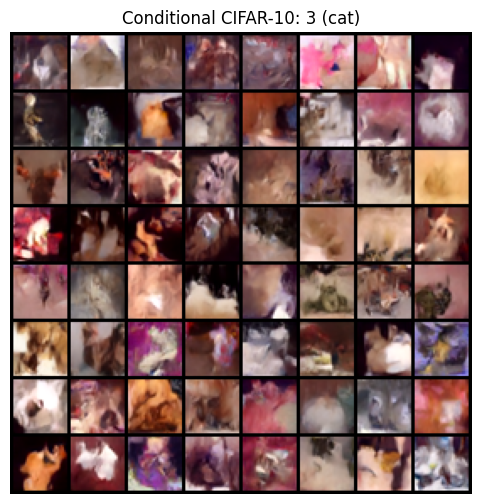

In [14]:
# ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
class_id = 3
samples = sample_conditional(class_id, n=64)

grid = utils.make_grid((samples + 1)/2, nrow=8)
plt.figure(figsize=(6,6))
plt.imshow(grid.permute(1,2,0).cpu())
plt.title(f"Conditional CIFAR-10: {class_id} ({cifar10_names[class_id]})")
plt.axis("off")
plt.show()
